In [1]:
# 1. IMPORTING LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import pywt

In [2]:
# 2. DATA PRE-PROCESSING 
# Plotting our dataset
data=pd.read_csv('AEP_hourly.csv')

In [4]:
# setting x and y axis 
x=data.index # extracts the index from the dataset and stores it in x
y=np.array(data.AEP_MW) # the line extracts the AEP_MW column and converts it into an array
data_array=pd.to_datetime(data.Datetime) # converts the DatTime column in the DataFrame to a pandas object and stores it in a data_array

Text(0, 0.5, 'MW energy consumption')

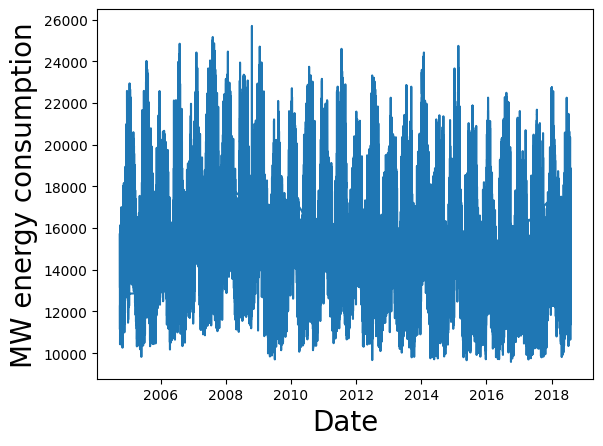

In [5]:
plt.plot(data_array,y) # plots the data_array on the x-axis and y on the y-axis
plt.xlabel('Date',fontsize=20)
plt.ylabel('MW energy consumption', fontsize=20)

Text(0, 0.5, 'Temperature')

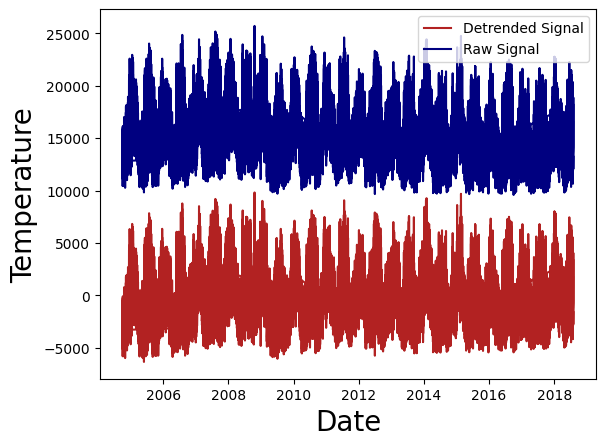

In [7]:
# Detrending refers to the process of removing trends from data. 
# A trend is a long-term increase or decrease in data, which can overshadow shorter-term patters or cycles
# Detreding helps us show the fluctuations around a zero mean 
y_detrend=signal.detrend(y) # detrending the data
plt.plot(data_array,y_detrend, color='firebrick', label='Detrended Signal') # plots the detrended data
plt.plot(data_array,y,color='navy', label='Raw Signal') # plots the raw data
plt.legend()
plt.xlabel('Date',fontsize=20)
plt.ylabel('Temperature', fontsize=20)

In [8]:
# 3. FREQUENCY ANALYSIS
# now we need to do a Fourier Transform to do a frequency analysis of our signal
# to plot the fourier transform
fourier_transf=np.fft.fft(y_detrend) # fourier transform of the detreded signal. The result is a complex array representing the frequency domain of the signal.
new_N=int(len(fourier_transf)/2) # new_N is set to half of the length of the FFT (Fast Fourier Transform) because the FFT output is symmetric, and we need only the first half for analysis.
f_nat=1 # this representsthe natural freuency 
new_X=np.linspace(10**-12, f_nat/2, new_N, endpoint=True) # the starting value is 10^-12 whcih is a value very close to zero. the stop value if f_nat/2, which represents the Nyquist frequency (half of the natural frequency). 
# The number of samples is set to new_N, which is half the length of the FFT result. This ensures we consider only the +ve values.
# Endpoint=True ensures that the stopoping value, 0.5 is included in the generated sequence.
# The purpose of this line, is to create a linearly spaced array new_X which represents the frequencies corresponding the first half of the FFT output.

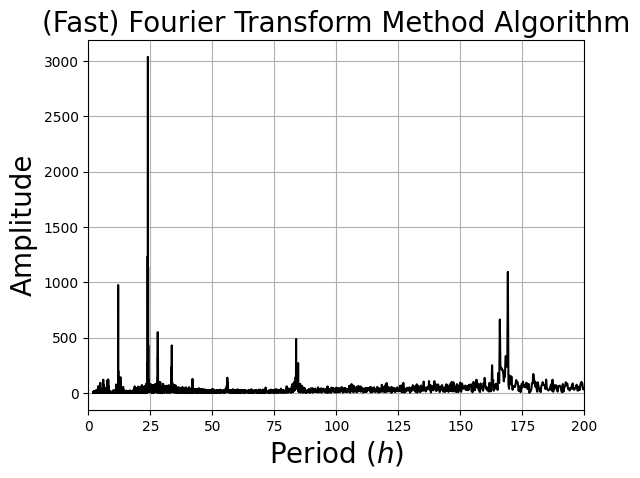

In [9]:
new_Xph=1.0/(new_X) # converts the frequencies to periods ( the reciprocal of frequency )
# we then need to calculate the amplitude spectrum
FFT_abs=np.abs(fourier_transf) # calculates the abs value of the FFT output
plt.plot(new_Xph, 2*FFT_abs[0:int(len(fourier_transf)/2.)]/len(new_Xph), color='black') # 
# the above statement plots the amplitude spectrum against the periods. The factor 2 is used to account for the symmetric part of FFT, and the division by len(new_Xph) normalizes the amplitude 
plt.xlabel('Period ($h$)', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.title('(Fast) Fourier Transform Method Algorithm', fontsize=20)
plt.grid(True)
plt.xlim(0,200)
plt.show()

In [10]:
# Int the plot above, we
# a. compute the FFT of the detnded time series data to transform it from the time domain to the frequency domain
# b. converts the frequency domain to periods for better interpretation of the data
# c. plots the amplitude spectrum against the periods to visualize the dominant cycles in the data
# from the above plot, we observe a peak at 12h, 24h, 80h.
# This means that the energy consumption pattern repeats approx every 24h, 12h or 80h. Such a pattern is common in many real world scenarios where consumption peaks during certain hours of the day.
# peaks symbolize a higher frequency at a given period, which means that the energy consumption pattern repeats at that period.

In [13]:
# We can sort the peaks and print the corresponding indexes:
fft_abs=2*FFT_abs[0:int(len(fourier_transf)/2.)]/len(new_Xph) #  extracts the first half of the FFT amplitude spectrum, scales the amplitude values by a factor of 2 and normalizes them by the number of samples.
fft_abs=pd.DataFrame(fft_abs, columns=['Amplitude']) # converts the FFT amplitude spectrum to a DataFrame with a single column named amplitude. this makes it easier to manipulate the data using pandas functions
fft_sorted=fft_abs.sort_values(by='Amplitude', ascending=False).head(20) # sorts the top 20 most significant amplitude values in descending order
fft_sorted

,Amplitude
5054,3037.558970
28,2556.509851
27,1636.961921
5068,1235.815611
5040,1137.886002
5055,1105.313718
717,1094.463940
10108,975.280091
10109,932.572475
14,895.208752


In [14]:
# printing the indexes as the number of days unit 
fft_sorted.index/24

Float64Index([ 210.58333333333334,  1.1666666666666667,               1.125,
               211.16666666666666,               210.0,             210.625,
                           29.875,   421.1666666666667,   421.2083333333333,
               0.5833333333333334,  1.0833333333333333,  210.54166666666666,
               1.0416666666666667,  30.458333333333332,  210.04166666666666,
               180.70833333333334,             421.125,  209.95833333333334,
               60.333333333333336, 0.16666666666666666],
             dtype='float64')

In [15]:
# 4. NOISE FILTERING (FOURIER TRANSFORM)
# we can take the highest peak as reference and filter the ones that are lower than 0.1,0.2,..,0.9 than this highest peak.
# for example, we can set everything below half (0.5) times the highest peak amplitude to 0.
# we must be careful since, if we set the threshold too high, we dont filter the noise only, but we filter important features as well.
# if the threshold is too low, we basically dont filter anything and we still keep the noise.


In [16]:
# defining the filtering function
def fft_filter(th): # takes the threshold as the input
    fft_tof=fourier_transf.copy() # create a copy of the FFT output
    fft_tof_abs=np.abs(fft_tof) # calculate the abs value
    fft_tof_abs=2*fft_tof_abs/len(new_Xph) # 2* for symmetric and /len(new_Xph) for normalization
    fft_tof[fft_tof_abs<=th]=0 # values below threshold are set to 0
    # co-effcients are the complex numbers obtained as a result of the FFT. They represent the amplitude and the phase of the various frequency components.
    return fft_tof # filters the co-efficients lesser than zero. 
# these can be used to reconstruct the time domain after filtering

In [19]:
# showing the plots at different threshold values
# defining the amplitude filtering function
def fft_filter_amp(th): # takes the threshold as the input
    fft_tof=fourier_transf.copy() # create a copy of the FFT output
    fft_tof_abs=np.abs(fft_tof) # calculate the abs value
    fft_tof_abs=2*fft_tof_abs/len(new_Xph) # 2* for symmetric and /len(new_Xph) for normalization
    fft_tof_abs[fft_tof_abs<=th]=0 
    return fft_tof_abs[0:int(len(fft_tof_abs)/2.)] # this function sets the amplitudes which are lesser than or equal the threshold to zero
# these represent which frequencies remain significant after filtering.

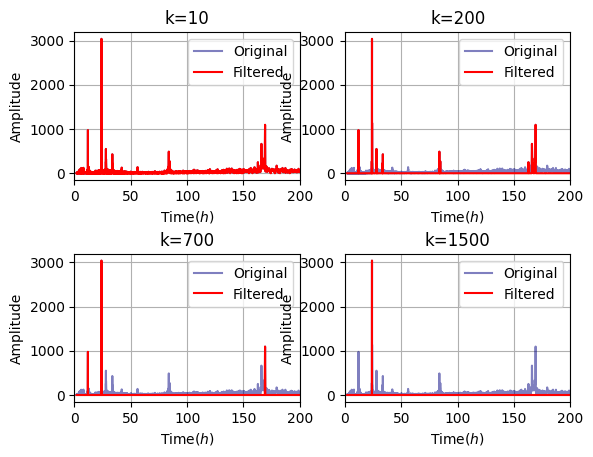

In [26]:
K_plot=[10,200,700,1500]
j=0
for k in K_plot:
    j=j+1
    plt.subplot(2,2,j)
    plt.title('k=%i'%(k))
    plt.xlim(0,200)
    plt.plot(new_Xph, 2*FFT_abs[0:int(len(fourier_transf)/2.)]/len(new_Xph), color='navy', alpha=0.5, label='Original')
    plt.grid(True)
    plt.plot(new_Xph, fft_filter_amp(k), 'red', label='Filtered')
    plt.xlabel('Time($h$)')
    plt.ylabel('Amplitude')
    plt.legend()
plt.subplots_adjust(hspace=0.5)